# Introduction

In [1]:
from google.colab import drive
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import lax
from typing import Dict

In [2]:
drive.mount('/content/drive')
sys.path.append('./scripts/utils/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import utils

ModuleNotFoundError: No module named 'utils'

In [3]:
# Import Utils and Libraries
%run '/content/drive/MyDrive/Projects/Hayfin Interview Assignment/scripts/utils/utils.py'
%run '/content/drive/MyDrive/Projects/Hayfin Interview Assignment/scripts/utils/financial.py'
%run '/content/drive/MyDrive/Projects/Hayfin Interview Assignment/scripts/utils/simulation.py'

In [4]:
np.random.seed(42)

# Helper Functions

# Internal Rate of Returns

We start by reading the data, converting dates to datetime objects, calculating the time column, and confirming that: $$total\_cf = coupon + delta\_notional * price$$

In [5]:
# Read data
data = read_and_parse_dates("/content/drive/MyDrive/Projects/Hayfin Interview Assignment/data/raw/simple_fixed_coupon_rates.csv")
data = add_time_column(data)
check_cashflow_consistency(data)

Number of mismatches: 0


In [6]:
# Proof of datetime type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   company         24 non-null     object        
 1   date            24 non-null     datetime64[ns]
 2   coupon          24 non-null     float64       
 3   delta_notional  24 non-null     float64       
 4   price           24 non-null     float64       
 5   total_cf        24 non-null     float64       
 6   time            24 non-null     float64       
 7   calculated_cf   24 non-null     float64       
 8   cf_match        24 non-null     bool          
dtypes: bool(1), datetime64[ns](1), float64(6), object(1)
memory usage: 1.7+ KB


## Cashflows

Plotting the cashflows as a function of time for each company.

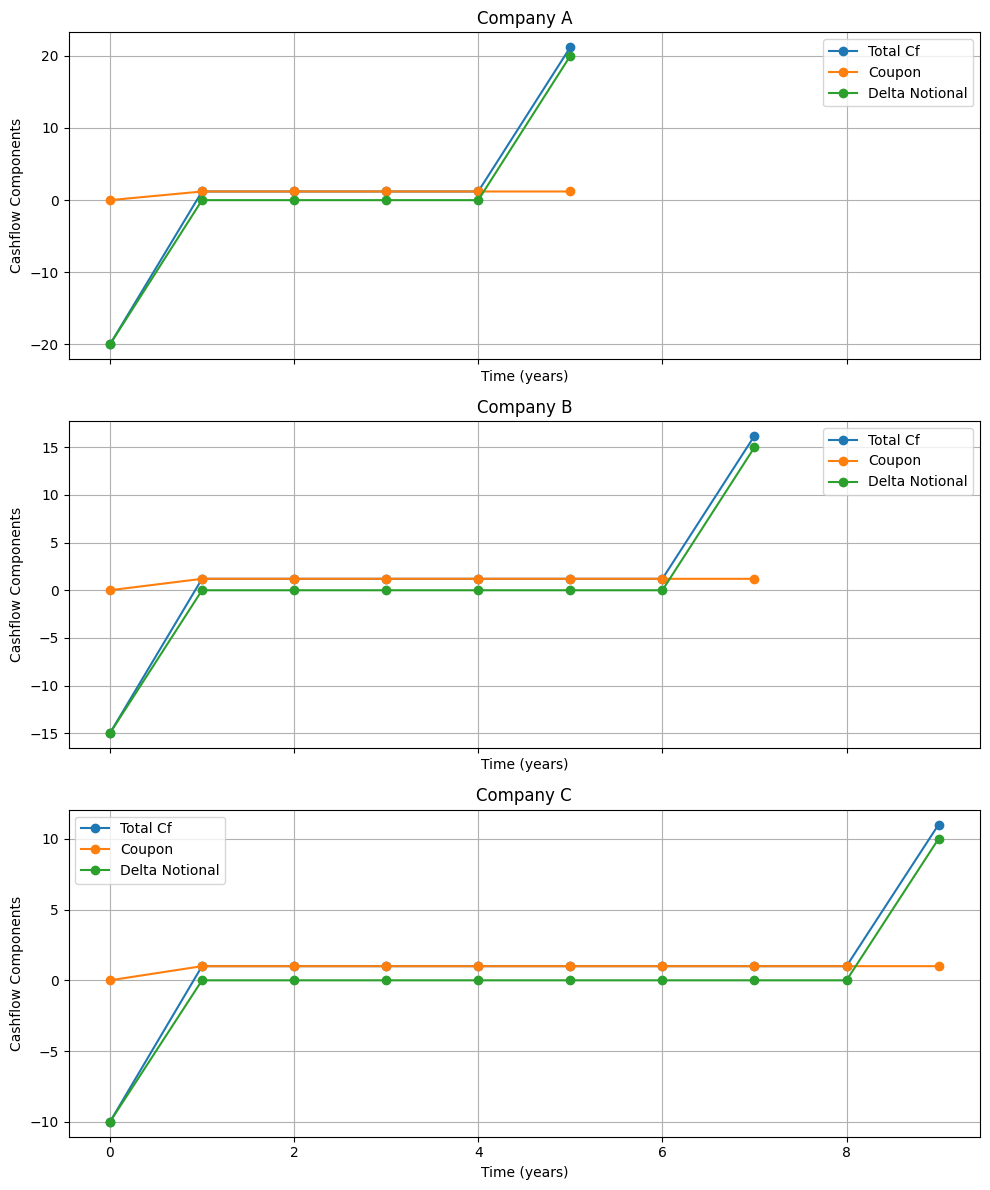

In [60]:
plot_grouped_time_series(
    df=data,
    group_col='company',
    time_col='time',
    value_cols=['total_cf', 'coupon', 'delta_notional'],
    title_prefix='Company',
    ylabel='Cashflow Components'
)

## NPV for different rates, separate and combined cashflows

For each company, compute NPV for each company at discount rates:

$r$=[0, 0.05, 0.1]:

In [61]:
rates_to_test = [0.00, 0.05, 0.10]

# Per-company NPVs
print(compute_grouped_npv(data, group_col='company', cashflow_col='total_cf', time_col='time', rates=[0.00, 0.05, 0.10]))

# Combined NPVs
print(compute_grouped_npv(data, group_col='combined', cashflow_col='total_cf', time_col='time', rates=[0.00, 0.05, 0.10]))

rate (%)      0.00      0.05      0.10
company                               
A         6.000003  0.753185 -3.379901
B         8.400000  2.482097 -1.807259
C         9.000000  3.444042 -0.291771
rate (%)       0.00      0.05      0.10
group                                  
All       23.400003  6.679324 -5.478932


Also combine all cashflows together:

## Gradients of NPV

Calculate the gradients of NPV with respect to $r$ using all the cashflows for the following rates.

In [62]:
# Combine all cashflows and times from your dataset
cf_all = jnp.array(data['total_cf'].values)
t_all = jnp.array(data['time'].values)

# Rates to evaluate
rates = [0.00, 0.05, 0.10]

# Run evaluation
evaluate_npv_and_gradients(cf_all, t_all, rates)

,npv,dNPV/dr
rate (%),,
0.00,23.400003,-391.600006
0.05,6.679324,-283.531738
0.10,-5.478932,-207.158844


## Internal Rate of Return

IRR for each company

In [63]:
# Original IRR by company
irr_by_company = evaluate_irr(data, combine=False)
print(irr_by_company)

# Original IRR for all cashflows combined
irr_combined = evaluate_irr(data, combine=True)
print(irr_combined)

# IRR after changing price at t=0 to 0.90 (by company)
irr_90, data_90 = evaluate_irr(data, new_price=0.90, change_price=True, combine=False)
print(irr_90)

# IRR after changing price at t=0 to 0.90 (combined)
irr_90_combined, _ = evaluate_irr(data, new_price=0.90, change_price=True, combine=True)
print(irr_90_combined)

# IRR after changing price at t=0 to 1.10 (by company)
irr_110, data_110 = evaluate_irr(data, new_price=1.10, change_price=True, combine=False)
print(irr_110)

# IRR after changing price at t=0 to 1.10 (combined)
irr_110_combined, _ = evaluate_irr(data, new_price=1.10, change_price=True, combine=True)
print(irr_110_combined)



         IRR (continuous)  IRR (simple)
company                                
A                0.058269          0.06
B                0.076961          0.08
C                0.095310          0.10
          IRR (continuous)  IRR (simple)
group                                   
Combined          0.075514      0.078438
         IRR (continuous)  IRR (simple)
company                                
A                0.081952      0.085403
B                0.095837      0.100580
C                0.112143      0.118673
          IRR (continuous)  IRR (simple)
group                                   
Combined          0.095342      0.100035
         IRR (continuous)  IRR (simple)
company                                
A                0.036991      0.037683
B                0.060118      0.061961
C                0.080420      0.083742
          IRR (continuous)  IRR (simple)
group                                   
Combined          0.057881      0.059588


IRR goes down, you pay more to receive the same stream of future cashflows.

## Task 10

10. Calculate the IRR gradient with respect to $cf$ and $t$. Only use Company A's cashflows for this exercise.

In [64]:
# -----------------------------
# Select Company A
# -----------------------------

df_A = data[data['company'] == 'A'].copy()
cf_A = jnp.array(df_A['total_cf'].values)

# Local time anchor (set t = 0 at first cashflow date for Company A)
min_date_A = df_A['date'].min()
t_A_local = jnp.array((df_A['date'] - min_date_A).dt.days / 365)

# -----------------------------
# Baseline IRR
# -----------------------------

r_base = IRR(cf_A, t_A_local)

# -----------------------------
# Perturb cf by +0.01 and compute new IRR
# -----------------------------

cf_perturbed = cf_A + 0.01
r_cf_perturbed = IRR(cf_perturbed, t_A_local)
delta_r_cf = r_cf_perturbed - r_base

# -----------------------------
# Perturb t by +1/12 year and compute new IRR
# -----------------------------

t_perturbed = t_A_local + 1/12
r_t_perturbed = IRR(cf_A, t_perturbed)
delta_r_t = r_t_perturbed - r_base

# -----------------------------
# Compute Gradients wrt cf and t
# -----------------------------

grad_cf = jax.grad(lambda cf: IRR(cf, t_A_local))(cf_A)
grad_t = jax.grad(lambda t: IRR(cf_A, t))(t_A_local)

# -----------------------------
# Approximate ΔIRR using gradients (first-order)
# -----------------------------

delta_cf = jnp.ones_like(cf_A) * 0.01
delta_t = jnp.ones_like(t_A_local) * (1 / 12)

approx_delta_r_cf = jnp.dot(grad_cf, delta_cf)
approx_delta_r_t = jnp.dot(grad_t, delta_t)

# -----------------------------
# Print results
# -----------------------------

print("=== BASELINE IRR (Company A) ===")
print(f"IRR (continuous): {r_base:.8f}")

print("\n=== Actual IRR Changes ===")
print(f"Δ IRR from cashflow +0.01     : {delta_r_cf:.12f}")
print(f"Δ IRR from time +1/12 year    : {delta_r_t:.12f}")

print("\n=== First-Order Approximations ===")
print(f"Estimated Δ IRR from grad_cf  : {approx_delta_r_cf:.12f}")
print(f"Estimated Δ IRR from grad_t   : {approx_delta_r_t:.12f}")

print("\n=== Interpretation ===")
print("- Positive ∂IRR/∂cf: IRR increases when future cashflows increase.")
print("- Negative ∂IRR/∂t: IRR decreases when cashflows are delayed.")
print("- First-order gradient approximations closely match actual IRR changes.")

=== BASELINE IRR (Company A) ===
IRR (continuous): 0.05826892

=== Actual IRR Changes ===
Δ IRR from cashflow +0.01     : 0.000583693385
Δ IRR from time +1/12 year    : 0.000000003725

=== First-Order Approximations ===
Estimated Δ IRR from grad_cf  : 0.000583677494
Estimated Δ IRR from grad_t   : 0.000000000116

=== Interpretation ===
- Positive ∂IRR/∂cf: IRR increases when future cashflows increase.
- Negative ∂IRR/∂t: IRR decreases when cashflows are delayed.
- First-order gradient approximations closely match actual IRR changes.


### Key Financial Insight

IRR is invariant to uniform shifts in time when the structure of the cashflows remains the same. This means:

* Pushing all cashflows forward by one month without changing spacing or scale doesn’t change their yield-to-cost ratio.
* IRR is more sensitive to changes in shape (e.g. front-loading vs back-loading payments), not simple shifts.



# Simulating Defaults

## Survival Probability Formulas

If $S$ = P(Survival Per Period) = $1 - PD = 0.85$

$P($no default over n periods$) = (1-PD)^n = 0.85^n$

## Simulating Cashflows with Default Risk

Simulated **cashflows**

In [114]:
# Setup
PD = 0.15
recovery_price = 0.7

# 11
n_periods = data[data['company'] == 'A'].shape[0]
print("Theoretical no-default prob:", prob_no_default(PD, n_periods))

Theoretical no-default prob: 0.37714951562499993


In [115]:
# 12
sim_results = simulate_defaults(data, PD, recovery_price)

In [117]:
# 13
total_cf_all = aggregate_total_cashflows(sim_results)
print("Avg total CF:", np.mean(total_cf_all))
print("Std total CF:", np.std(total_cf_all))

Avg total CF: -12.211679999999976
Std total CF: 16.166925235727422


In [118]:
irrs = simulate_irrs(sim_results)

In [119]:
print("Valid IRRs:", len(irrs))
print("Avg IRR:", np.mean(irrs))
print("Std IRR:", np.std(irrs))

Valid IRRs: 9964
Avg IRR: -0.16472873
Std IRR: 0.29015368


Q14:
  Average IRR: -16.4729%
  Std. Dev IRR: 29.0154%


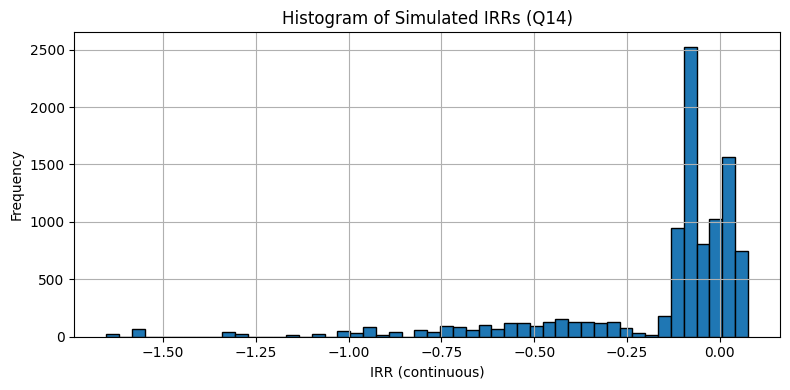

In [120]:
import matplotlib.pyplot as plt

# Step 1: Stack all company CF matrices and times
cf_matrix = np.vstack([v['cf_mat'] for v in sim_results.values()])     # shape (n_periods_total, n_sims)
time_vector = np.concatenate([v['times'] for v in sim_results.values()])  # shape (n_periods_total,)

# Step 2: Convert to JAX arrays
cf_matrix_jax = jnp.array(cf_matrix.T)     # shape (n_sims, n_periods_total)
time_vector_jax = jnp.array(time_vector)   # shape (n_periods_total,)

# Step 3: Vectorized IRR with safety wrapper
@vmap
def compute_irr_safe(cf_row):
    is_zero = jnp.all(cf_row == 0.0)
    return lax.cond(is_zero,
                    lambda _: jnp.nan,
                    lambda _: IRR(cf_row, time_vector_jax),
                    operand=None)

irrs = np.array(compute_irr_safe(cf_matrix_jax))
irrs = irrs[~np.isnan(irrs)]

# Step 4: Report stats and plot
print("Q14:")
print(f"  Average IRR: {irrs.mean():.4%}")
print(f"  Std. Dev IRR: {irrs.std():.4%}")

plt.figure(figsize=(8, 4))
plt.hist(irrs, bins=50, edgecolor='k')
plt.title("Histogram of Simulated IRRs (Q14)")
plt.xlabel("IRR (continuous)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [121]:
from scipy.optimize import brentq

# Step 1: Compute IRR with no defaults
df_no_default = data.copy()
df_no_default['total_cf'] = df_no_default['coupon'] + df_no_default['delta_notional'] * df_no_default['price']
cf_no_default = df_no_default.groupby('time')['total_cf'].sum().sort_index().to_numpy()
t_no_default  = df_no_default.groupby('time')['time'].first().sort_index().to_numpy()

IRR_no_default = IRR(jnp.array(cf_no_default), jnp.array(t_no_default))
print(f"IRR (no default): {IRR_no_default:.4%}")

# Step 2: Define objective function to match simulated IRR to no-default IRR
def expected_irr_given_price(p0):
    df_p = data.copy()
    t0 = df_p['time'].min()
    df_p.loc[df_p['time'] == t0, 'price'] = p0
    df_p['total_cf'] = df_p['coupon'] + df_p['delta_notional'] * df_p['price']

    sim_res_p = simulate_defaults(df_p, PD, recovery_price)
    cf_mat = np.vstack([v['cf_mat'] for v in sim_res_p.values()])
    times = np.concatenate([v['times'] for v in sim_res_p.values()])

    cf_mat_jax = jnp.array(cf_mat.T)
    times_jax = jnp.array(times)

    @vmap
    def irr_sim(cf_row):
        is_zero = jnp.all(cf_row == 0.0)
        return lax.cond(is_zero,
                        lambda _: jnp.nan,
                        lambda _: IRR(cf_row, times_jax),
                        operand=None)

    irrs_p = np.array(irr_sim(cf_mat_jax))
    irrs_p = irrs_p[~np.isnan(irrs_p)]

    return irrs_p.mean()

# Step 3: Root find entrance price P0 such that expected IRR ≈ IRR_no_default
def price_objective(p0):
    return expected_irr_given_price(p0) - float(IRR_no_default)

fair_price = brentq(price_objective, 0.15, 0.5)
print(f"Q15: Fair entrance price P0 = {fair_price:.4f}")


IRR (no default): 7.5514%
Q15: Fair entrance price P0 = 0.3703


In [122]:
print(f"P0 = 0.15 → IRR = {expected_irr_given_price(0.15):.4%}")
print(f"P0 = 0.5 → IRR = {expected_irr_given_price(0.5):.4%}")
print(f"Target IRR (no default) = {float(IRR_no_default):.4%}")

P0 = 0.15 → IRR = 36.1476%
P0 = 0.5 → IRR = -0.4801%
Target IRR (no default) = 7.5514%
